# Plot summaries of auditory fMRI responses (Figure 8)

The variance explained for each voxel for each split of data is saved within the "regression_results/natsound_activations/" directory for each model (and is included in the github repo).  

This notebook loads in the data, computes the voxel and participant medians, and performs the leave-one-participant out anlaysis to determine the "best layer" for each set of voxels. 

The permutation tests for significance values are performed at the end of the notebook. 

In [1]:
import numpy as np
import pickle

import os

import matplotlib.pylab as plt
import matplotlib
%matplotlib inline

from model_analysis_folders import all_model_info

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import seaborn as sns
from scipy.stats import ttest_rel


In [2]:
all_networks_and_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_AUDIO

# Modified this color map to make the greens more distinguished from black.
# also modified to make the black a little more grey. 
cmap_plotting = ["#000000", # "#525252",# 
                 "#99cc99","#009933","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

model_colors = {'kell2018':cmap_plotting[0],
                 'kell2018_l2_p5_robust_cochleagram':cmap_plotting[1],
                 'kell2018_l2_1_robust_cochleagram':cmap_plotting[2],
                  'cochresnet50':cmap_plotting[0],
                  'cochresnet50_l2_p5_robust_cochleagram':cmap_plotting[1],
                  'cochresnet50_l2_1_robust_cochleagram':cmap_plotting[2],
                  'spectemp_filters':"#979797",# 'grey',
               }

In [3]:
# copy the used fMRI files to the public github
def split_voxel_data_by_participant(voxel_data, voxel_meta):
    subj_idx = voxel_meta['subj_idx']
    all_participants = []
    participant_ids = np.unique(subj_idx)
    for participant_id in participant_ids:
        all_participants.append(voxel_data[:,subj_idx==participant_id,:])
    return participant_ids, all_participants

def split_roi_data_by_participant(voxel_data, voxel_meta, roi_masks):
    subj_idx = voxel_meta['subj_idx']
    all_participants = []
    participant_ids = np.unique(subj_idx)
    for participant_id in participant_ids:
        all_participants.append({roi_name: voxel_data[:,(np.logical_and(subj_idx==participant_id,  
                                                         roi_masks['masks'][:,roi_idx].astype(bool))),:] 
                                 for roi_idx, roi_name in enumerate(roi_masks['mask_names'])})
        all_participants[-1]['all_aud_voxels'] = voxel_data[:,subj_idx==participant_id,:]
    return participant_ids, all_participants


def load_all_voxel_predictions(all_networks_and_layers, model_name,
                               spectemp_filter_layer='avgpool'):
    """
    Loads in the voxel predictions for a given model. 
    
    Inputs:
        all_networks_and_layers (dict): contains all of the info about the models
        model_name (string): contains the model name, used to load and save
    """
    all_conv_layers = all_networks_and_layers[model_name]['layers']
    if (model_name == 'spectemp_filters') and (spectemp_filter_layer is not None):
        all_conv_layers = [spectemp_filter_layer]
#         print('Loading Single Layer for Spectemp!')
    neural_location = os.path.join(all_networks_and_layers[model_name]['location'], 
                                   all_networks_and_layers[model_name]['neural_regression_folder'])
    neural_analysis_string = all_networks_and_layers[model_name]['neural_analysis_string']
    all_r2 = {}
    all_alphas = {}
    n_layers = len(all_conv_layers)
    
    all_voxel_info = {}
        
    for conv_idx, layer in enumerate(all_conv_layers):
        try:
            save_path = os.path.join(neural_location, 'natsound_activations', neural_analysis_string%layer.split('_fake')[0])
                        
            info = pickle.load(open(save_path, 'rb'))
            if conv_idx == 0:
                n_vox = info['r2s'].shape[0]
                n_samples = info['r2s'].shape[1]
                all_r2 = np.zeros([n_layers, n_vox, n_samples])
                all_alphas = np.zeros([n_layers, n_vox, n_samples])
                all_voxel_info = {'roi_masks': info['roi_masks'], 
                                  'voxel_meta': info['voxel_meta']}
            
            all_r2[conv_idx,:] = info['r2s']
            all_alphas[conv_idx,:] = info['alphas']
            
        except FileNotFoundError:
            print('%s not Found'%(os.path.join(neural_location, 'natsound_activations', neural_analysis_string%layer)))
            all_r2[conv_idx,:] = np.nan
            all_alphas[conv_idx,:] = np.nan
            
    
    return all_r2, all_alphas, all_voxel_info



In [4]:
def plot_roi_analysis_for_models(models_to_plot,
                                 model_colors,
                                 spectemp_layer='avgpool',
                                 roi_names = None
                                 ):
    """
    Makes the roi analysis neural predictions analysis plots.
    Holds one participant out and determines the "best layer" from the remaining participants. 
    Saves the subject-wise data as a .mat file for ANOVA analysis
    """
    if roi_names is None:
        plt.figure(figsize=(4,3))
    else:
        plt.figure(figsize=(1.25*len(roi_names),3))

    median_for_each_roi_and_model = {}
    models_roi_r2 = {}
    models_roi_alphas = {}
    
    all_model_results = []
    all_position_data = []
    
    bar_width = (0.7 / len(models_to_plot))
    bar_spacing = 0.05
    
    middle_idx = np.ceil(len(models_to_plot)/2)
    

    for model_idx, model_name in enumerate(models_to_plot):
        print('model')
        all_conv_layers = all_networks_and_layers[model_name]['layers']
        all_r2, all_alphas, all_voxel_info = load_all_voxel_predictions(all_networks_and_layers, model_name)
        roi_masks = all_voxel_info['roi_masks']
        
        if roi_names is None:
            roi_names = roi_masks['mask_names']
        
        all_roi_data = []
        for roi_idx, roi_name in enumerate(roi_names):           
            median_for_each_roi_and_model[model_name] = {}
            print('Model: %s'%model_name)

            participant_ids, all_participants = split_roi_data_by_participant(all_r2, 
                                                                              all_voxel_info['voxel_meta'],
                                                                              roi_masks)

            all_participants_median_layer_data = []
            all_participants_median_layer_data_mean_subtracted = []

            for participant_idx, participant_all_data in enumerate(all_participants):
                participant = participant_all_data[roi_name]
                # Take the mean across the 10 splits first, and use that as the layer-voxel pair. 
                median_layer_voxel_data = np.nanmedian(participant,2)
                # Take the median for each layer -- this is the value for each participant. 
                median_layer_data = np.nanmedian(median_layer_voxel_data,1)

                median_layer_data_mean_subtracted = median_layer_data - np.nanmean(median_layer_data)

                all_participants_median_layer_data.append(median_layer_data)
                all_participants_median_layer_data_mean_subtracted.append(median_layer_data_mean_subtracted)

            all_participants_median_layer_data = np.array(all_participants_median_layer_data)
            
            participant_roi_from_held_out = []
            for participant_idx, participant_all_data in enumerate(all_participants):
                participants_to_measure = list(range(len(participant_ids)))
                participants_to_measure.pop(participant_idx) # remove the participant we are holding out
                # Kell2018 used a fisher transform here before averaging because these are r^2 values. 
                # Not doing it here, but could if we want to fully replicate. 
                average_layer_data = np.nanmean(all_participants_median_layer_data[participants_to_measure,:],0)
                best_layer = np.argmax(average_layer_data)
                participant_roi_from_held_out.append(np.nanmean(all_participants_median_layer_data[participant_idx, 
                                                                                                best_layer]))
            
            all_roi_data.append(participant_roi_from_held_out)
        
        all_roi_data = np.array(all_roi_data)
        mean_subtract_roi_data = all_roi_data - np.mean(all_roi_data,0)
        
        sem = np.std(all_roi_data, 1, ddof=1)/np.sqrt(len(all_participants))
        
        roi_mean = np.mean(all_roi_data, 1)

        positions = np.arange(len(roi_names))-(bar_width+bar_spacing)*(len(models_to_plot) - model_idx)
                              
        ##### Set style options here #####
        boxprops = dict(linestyle='-', linewidth=1, color='k')
        whiskerprops = dict(color='k')
        capprops = dict(color='k')
        medianprops = dict(linewidth=1, linestyle='-', color='k')
            
        this_position_data = []
        
        for x_location, val, m_val, m_sem in zip(positions, all_roi_data, 
                                                 roi_mean, sem):
            
            plt.errorbar(x_location+0.1,
                    m_val,
                    yerr = m_sem,
                    color=model_colors[model_name],
                    fmt='_',
                    linewidth=1,
                    zorder=200
                   )
            
            plt.scatter(x_location*np.ones(val.shape), val, s=40,
                        color=model_colors[model_name],
                        label=model_name,
                        alpha=0.8,
                        linewidth=0,
                        zorder=100)
            
            this_position_data.append(x_location*np.ones(val.shape))
        
        if len(this_position_data)==1:
            plt.legend(models_to_plot, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
        plt.ylim([0,1])
        all_model_results.append(all_roi_data)
        all_position_data.append(this_position_data)
        
    plt.xticks(np.arange(len(roi_names))-(bar_width+bar_spacing)*(int(len(models_to_plot)/2))-bar_spacing, 
               roi_names,
               rotation=90,
               )
    plt.tick_params(axis="x", bottom=False)
    plt.ylabel('Variance Explained')
            
    num_models, num_rois, num_participants = np.array(all_model_results).shape
    
    for roi_plot_idx in range(num_rois):
        for participant_plot_idx in range(num_participants):
            plt.plot(np.array(all_position_data)[:, roi_plot_idx, participant_plot_idx],
                     np.array(all_model_results)[:, roi_plot_idx, participant_plot_idx], 
                     color='k',
                     alpha=0.6,
                     zorder=90,
                     linewidth=0.5
                     )
    
    plt.plot()
    sns.despine()
    
    plt.savefig('%s-ROIs-%s.pdf'%('_'.join(models_to_plot), '_'.join(roi_names)))
    


model
Model: cochresnet50
model
Model: cochresnet50_l2_p5_robust_cochleagram
model
Model: cochresnet50_l2_1_robust_cochleagram
model
Model: spectemp_filters
model
Model: cochresnet50
Model: cochresnet50
Model: cochresnet50
Model: cochresnet50
model
Model: cochresnet50_l2_p5_robust_cochleagram
Model: cochresnet50_l2_p5_robust_cochleagram
Model: cochresnet50_l2_p5_robust_cochleagram
Model: cochresnet50_l2_p5_robust_cochleagram
model
Model: cochresnet50_l2_1_robust_cochleagram
Model: cochresnet50_l2_1_robust_cochleagram
Model: cochresnet50_l2_1_robust_cochleagram
Model: cochresnet50_l2_1_robust_cochleagram
model
Model: spectemp_filters
Model: spectemp_filters
Model: spectemp_filters
Model: spectemp_filters


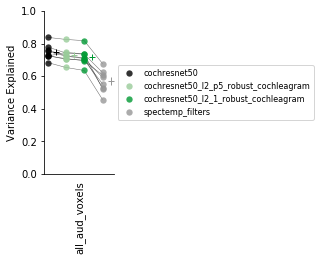

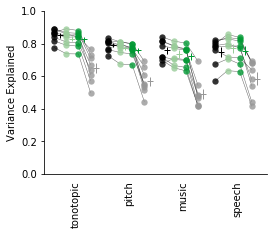

In [5]:
models_to_plot = [
#                   'kell2018',
#                   'kell2018_l2_1_robust_waveform',
#                   'kell2018_l2_1_robust_cochleagram',
#                   'spectemp_filters'
                  'cochresnet50',
                  'cochresnet50_l2_p5_robust_cochleagram',
                  'cochresnet50_l2_1_robust_cochleagram',
                  'spectemp_filters'
                 ]

plot_roi_analysis_for_models(models_to_plot,
                             model_colors,
                             roi_names=['all_aud_voxels']
                                   )

plot_roi_analysis_for_models(models_to_plot,
                                   model_colors,
                                   )


model
Model: kell2018
model
Model: kell2018_l2_p5_robust_cochleagram
model
Model: kell2018_l2_1_robust_cochleagram
model
Model: spectemp_filters
model
Model: kell2018
Model: kell2018
Model: kell2018
Model: kell2018
model
Model: kell2018_l2_p5_robust_cochleagram
Model: kell2018_l2_p5_robust_cochleagram
Model: kell2018_l2_p5_robust_cochleagram
Model: kell2018_l2_p5_robust_cochleagram
model
Model: kell2018_l2_1_robust_cochleagram
Model: kell2018_l2_1_robust_cochleagram
Model: kell2018_l2_1_robust_cochleagram
Model: kell2018_l2_1_robust_cochleagram
model
Model: spectemp_filters
Model: spectemp_filters
Model: spectemp_filters
Model: spectemp_filters


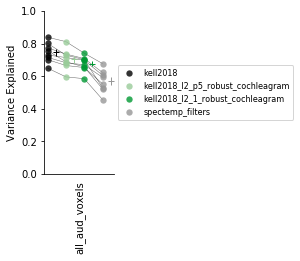

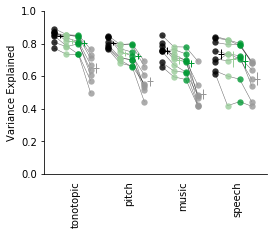

In [6]:
models_to_plot = [
                  'kell2018',
                  'kell2018_l2_p5_robust_cochleagram',
                  'kell2018_l2_1_robust_cochleagram',
                  'spectemp_filters'
#                   'cochresnet50',
#                   'cochresnet50_l2_p5_robust_cochleagram',
#                   'cochresnet50_l2_1_robust_cochleagram',
#                   'spectemp_filters'
                 ]

plot_roi_analysis_for_models(models_to_plot,
                             model_colors,
                             roi_names=['all_aud_voxels']
                                   )

plot_roi_analysis_for_models(models_to_plot,
                                   model_colors,
                                   )


# Statistics (Permutation Tests)

One-sided paired-sample t-tests were performed 

We performed the following analyses on all voxels:  

1) Trained neural networks explain more variance than the spectemp model for each model. 

2) Varianced explained from standard model > each adversarially robust model (where there was a small effect)
 
We perform the following two analysis for each ROI and report the max/min p-value/t-test in the paper. 

1) Trained neural networks explain more variances than the spectemp model for each ROI and each model. 

2) Varianced explained from adversarially robust model > than the standard model (no effect). 

Note that the 


In [17]:
np.random.seed(0)

def run_boot_one_sided_t_comparison_between_models(model_1, model_2, roi_name,
                                      spectemp_layer='avgpool',
                                      ):
    """
    Gets significance values between two conditions. Tests for model_1 > model_2. 
    Holds one participant out and determines the "best layer" from the remaining participants. 
    Saves the subject-wise data as a .mat file for ANOVA analysis
    """
    median_for_each_roi_and_model = {}
    models_roi_r2 = {}
    models_roi_alphas = {}
    
    all_model_results = {}
    
    for model_idx, model_name in enumerate([model_1, model_2]):
        all_conv_layers = all_networks_and_layers[model_name]['layers']
        all_r2, all_alphas, all_voxel_info = load_all_voxel_predictions(all_networks_and_layers, model_name)
        roi_masks = all_voxel_info['roi_masks']
                
        median_for_each_roi_and_model[model_name] = {}
        participant_ids, all_participants = split_roi_data_by_participant(all_r2, 
                                                                          all_voxel_info['voxel_meta'],
                                                                          roi_masks)

        all_participants_median_layer_data = []
        all_participants_median_layer_data_mean_subtracted = []

        for participant_idx, participant_all_data in enumerate(all_participants):
            participant = participant_all_data[roi_name]
            # Take the mean across the 10 splits first, and use that as the layer-voxel pair. 
            median_layer_voxel_data = np.nanmedian(participant,2)
            # Take the median for each layer -- this is the value for each participant. 
            median_layer_data = np.nanmedian(median_layer_voxel_data,1)

            median_layer_data_mean_subtracted = median_layer_data - np.nanmean(median_layer_data)

            all_participants_median_layer_data.append(median_layer_data)
            all_participants_median_layer_data_mean_subtracted.append(median_layer_data_mean_subtracted)

        all_participants_median_layer_data = np.array(all_participants_median_layer_data)
        participant_roi_from_held_out = []
            
        for participant_idx, participant_all_data in enumerate(all_participants):
            participants_to_measure = list(range(len(participant_ids)))
            participants_to_measure.pop(participant_idx) # remove the participant we are holding out
            # Kell2018 used a fisher transform here before averaging because these are r^2 values. 
            # Not doing it here, but could if we want to fully replicate. 
            average_layer_data = np.nanmean(all_participants_median_layer_data[participants_to_measure,:],0)
            best_layer = np.argmax(average_layer_data)
            participant_roi_from_held_out.append(np.nanmean(all_participants_median_layer_data[participant_idx, 
                                                                                            best_layer]))

        all_roi_data = participant_roi_from_held_out
        
        all_roi_data = np.array(all_roi_data)
        sem = np.std(all_roi_data, 0, ddof=1)/np.sqrt(len(all_participants))
        
        roi_mean = np.mean(all_roi_data, 0)
        all_model_results[model_name] = all_roi_data
                        
    model_pair = [model_1, model_2]
    print('Testing Models %s-%s'%(model_pair[0], model_pair[1]))

    model_data_1 = all_model_results[model_pair[0]]
    model_data_2 = all_model_results[model_pair[1]]

    num_bootstraps = 10000
    # Python paired sample t-test
    print('ROI: %s'%roi_name)
    true_data_stats = ttest_rel(model_data_1[:],
                                model_data_2[:],
                                # alternative='less' # used an older version of scipy for this project. 
                               )    
    print(true_data_stats, '(note: this p-value is parametric and two-sided)')
    combined_data = np.stack((model_data_1[:], 
                             model_data_2[:]), axis=1)
    true_means = np.mean(combined_data,0)
    true_mean_difference = true_means[0] - true_means[1]
    all_bootstrap_means_difference = []
    all_bootstrap_t_values = []

    for i in range(num_bootstraps):
        shuffle_participants = combined_data.copy()
        # shuffle each row in place. 
        for i in range(shuffle_participants.shape[0]):
            np.random.shuffle(shuffle_participants[i,:])
        permuted_data_stats_t, _ = ttest_rel(shuffle_participants[:,0],
                                        shuffle_participants[:,1],
                                        )
        mean_values_perm = np.mean(shuffle_participants,0)
        all_bootstrap_means_difference.append(mean_values_perm[0] - mean_values_perm[1])
        all_bootstrap_t_values.append(permuted_data_stats_t)

    num_possibilities = min(num_bootstraps, combined_data.shape[1]**combined_data.shape[0])    
        
    # We want a one-sided t-test (testing for the first value to be higher or equal to the second)
    bootstrap_p = np.sum(np.array(all_bootstrap_means_difference)>true_mean_difference)/num_bootstraps
    if bootstrap_p==0:
        bootstrap_p = 1/num_possibilities
    print('bootstrap p-value: %f'%(bootstrap_p))                            

    bootstrap_p_from_t = np.sum((np.array(all_bootstrap_t_values))>(true_data_stats[0]))/num_bootstraps
    if bootstrap_p_from_t==0:
        bootstrap_p_from_t = 1/num_possibilities
    print('bootstrap p-value from t: %f \n \n'%(bootstrap_p_from_t))   
    return true_data_stats[0], bootstrap_p_from_t

In [18]:
# Compare all models against the spectrotemporal model (for all auditory voxels)

all_bootstrap_t_values = run_boot_one_sided_t_comparison_between_models('cochresnet50', 'spectemp_filters', 
                                               'all_aud_voxels')

all_bootstrap_t_values = run_boot_one_sided_t_comparison_between_models('cochresnet50_l2_p5_robust_cochleagram', 'spectemp_filters', 
                                               'all_aud_voxels')

all_bootstrap_t_values = run_boot_one_sided_t_comparison_between_models('cochresnet50_l2_1_robust_cochleagram', 'spectemp_filters', 
                                               'all_aud_voxels')

all_bootstrap_t_values = run_boot_one_sided_t_comparison_between_models('kell2018', 'spectemp_filters', 
                                               'all_aud_voxels')

all_bootstrap_t_values = run_boot_one_sided_t_comparison_between_models('kell2018_l2_p5_robust_cochleagram', 'spectemp_filters', 
                                               'all_aud_voxels')

all_bootstrap_t_values = run_boot_one_sided_t_comparison_between_models('kell2018_l2_1_robust_cochleagram', 'spectemp_filters', 
                                               'all_aud_voxels')



Testing Models cochresnet50-spectemp_filters
ROI: all_aud_voxels
Ttest_relResult(statistic=13.120954142150469, pvalue=3.48454230597609e-06) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.003906
bootstrap p-value from t: 0.003906 
 

Testing Models cochresnet50_l2_p5_robust_cochleagram-spectemp_filters
ROI: all_aud_voxels
Ttest_relResult(statistic=10.475920147744395, pvalue=1.5733777622474446e-05) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.003906
bootstrap p-value from t: 0.003906 
 

Testing Models cochresnet50_l2_1_robust_cochleagram-spectemp_filters
ROI: all_aud_voxels
Ttest_relResult(statistic=9.912181737759306, pvalue=2.2674455133181865e-05) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.003906
bootstrap p-value from t: 0.003906 
 

Testing Models kell2018-spectemp_filters
ROI: all_aud_voxels
Ttest_relResult(statistic=9.310805882586687, pvalue=3.418714328048967e-05) (note: this p-value is parametric and two-si

In [19]:
# Compare standard vs. Robust for all aud voxels
all_bootstrap_t_values = run_boot_one_sided_t_comparison_between_models('cochresnet50','cochresnet50_l2_1_robust_cochleagram', 
                                               'all_aud_voxels')


all_bootstrap_t_values = run_boot_one_sided_t_comparison_between_models('cochresnet50','cochresnet50_l2_p5_robust_cochleagram',  
                                               'all_aud_voxels')

all_bootstrap_t_values = run_boot_one_sided_t_comparison_between_models('kell2018', 'kell2018_l2_1_robust_cochleagram', 
                                               'all_aud_voxels')


all_bootstrap_t_values = run_boot_one_sided_t_comparison_between_models('kell2018', 'kell2018_l2_p5_robust_cochleagram', 
                                               'all_aud_voxels')



Testing Models cochresnet50-cochresnet50_l2_1_robust_cochleagram
ROI: all_aud_voxels
Ttest_relResult(statistic=4.217445589153616, pvalue=0.003949094283447975) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.004000
bootstrap p-value from t: 0.004000 
 

Testing Models cochresnet50-cochresnet50_l2_p5_robust_cochleagram
ROI: all_aud_voxels
Ttest_relResult(statistic=3.0055042546488964, pvalue=0.019787493784581497) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.011100
bootstrap p-value from t: 0.011100 
 

Testing Models kell2018-kell2018_l2_1_robust_cochleagram
ROI: all_aud_voxels
Ttest_relResult(statistic=7.257452548081833, pvalue=0.00016883906656904737) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.003906
bootstrap p-value from t: 0.003906 
 

Testing Models kell2018-kell2018_l2_p5_robust_cochleagram
ROI: all_aud_voxels
Ttest_relResult(statistic=6.084893511822604, pvalue=0.0004984534914929515) (note: this p-value is par

In [20]:
# Compare all individual ROIs against the spectemp

all_t_values = []
all_p_values = []

for roi_name in ['tonotopic', 'pitch', 'music', 'speech']:

    t_temp, p_temp = run_boot_one_sided_t_comparison_between_models('cochresnet50', 'spectemp_filters', 
                                                   roi_name)
    all_t_values.append(t_temp)
    all_p_values.append(p_temp)

    t_temp, p_temp = run_boot_one_sided_t_comparison_between_models('cochresnet50_l2_p5_robust_cochleagram', 'spectemp_filters', 
                                                   roi_name)
    all_t_values.append(t_temp)
    all_p_values.append(p_temp)

    t_temp, p_temp = run_boot_one_sided_t_comparison_between_models('cochresnet50_l2_1_robust_cochleagram', 'spectemp_filters', 
                                                   roi_name)
    all_t_values.append(t_temp)
    all_p_values.append(p_temp)

    t_temp, p_temp = run_boot_one_sided_t_comparison_between_models('kell2018', 'spectemp_filters', 
                                                   roi_name)
    all_t_values.append(t_temp)
    all_p_values.append(p_temp)

    t_temp, p_temp = run_boot_one_sided_t_comparison_between_models('kell2018_l2_p5_robust_cochleagram', 'spectemp_filters', 
                                                   roi_name)
    all_t_values.append(t_temp)
    all_p_values.append(p_temp)

    t_temp, p_temp = run_boot_one_sided_t_comparison_between_models('kell2018_l2_1_robust_cochleagram', 'spectemp_filters', 
                                                   roi_name)
    all_t_values.append(t_temp)
    all_p_values.append(p_temp)

print('Minimum T-value = %f'%min(all_t_values))
print('Maximum p-value = %f'%max(all_p_values))



Testing Models cochresnet50-spectemp_filters
ROI: tonotopic
Ttest_relResult(statistic=9.189609067706414, pvalue=3.7240246435813416e-05) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.003906
bootstrap p-value from t: 0.003906 
 

Testing Models cochresnet50_l2_p5_robust_cochleagram-spectemp_filters
ROI: tonotopic
Ttest_relResult(statistic=9.37588757240503, pvalue=3.2665287596906346e-05) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.003906
bootstrap p-value from t: 0.003906 
 

Testing Models cochresnet50_l2_1_robust_cochleagram-spectemp_filters
ROI: tonotopic
Ttest_relResult(statistic=9.0381786965439, pvalue=4.149821519693405e-05) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.003906
bootstrap p-value from t: 0.003906 
 

Testing Models kell2018-spectemp_filters
ROI: tonotopic
Ttest_relResult(statistic=7.147233831254966, pvalue=0.0001858088064752753) (note: this p-value is parametric and two-sided)
bootstrap p-value: 

In [21]:
# Adversarial vs. Standard all ROI analysis (test here that no adv. model is greater)

all_t_values = []
all_p_values = []

for roi_name in ['tonotopic', 'pitch', 'music', 'speech']:
    t_temp, p_temp = run_boot_one_sided_t_comparison_between_models('cochresnet50_l2_1_robust_cochleagram', 'cochresnet50',
                                                   roi_name)
    all_t_values.append(t_temp)
    all_p_values.append(p_temp)

    t_temp, p_temp = run_boot_one_sided_t_comparison_between_models('cochresnet50_l2_p5_robust_cochleagram', 'cochresnet50', 
                                                   roi_name)
    all_t_values.append(t_temp)
    all_p_values.append(p_temp)

    t_temp, p_temp = run_boot_one_sided_t_comparison_between_models('kell2018_l2_1_robust_cochleagram', 'kell2018', 
                                                   roi_name)
    all_t_values.append(t_temp)
    all_p_values.append(p_temp)

    t_temp, p_temp = run_boot_one_sided_t_comparison_between_models('kell2018_l2_p5_robust_cochleagram', 'kell2018', 
                                                   roi_name)
    all_t_values.append(t_temp)
    all_p_values.append(p_temp)

    
print('Max T-value = %f'%max(all_t_values))
print('Minimum p-value = %f'%min(all_p_values))


Testing Models cochresnet50_l2_1_robust_cochleagram-cochresnet50
ROI: tonotopic
Ttest_relResult(statistic=-3.8586987728654543, pvalue=0.006221965269205193) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.991300
bootstrap p-value from t: 0.991300 
 

Testing Models cochresnet50_l2_p5_robust_cochleagram-cochresnet50
ROI: tonotopic
Ttest_relResult(statistic=-3.1725844394498446, pvalue=0.01565140465051712) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.983500
bootstrap p-value from t: 0.983500 
 

Testing Models kell2018_l2_1_robust_cochleagram-kell2018
ROI: tonotopic
Ttest_relResult(statistic=-3.438891619339584, pvalue=0.010853491940139475) (note: this p-value is parametric and two-sided)
bootstrap p-value: 0.997200
bootstrap p-value from t: 0.997200 
 

Testing Models kell2018_l2_p5_robust_cochleagram-kell2018
ROI: tonotopic
Ttest_relResult(statistic=-4.745785461963407, pvalue=0.0020937423216648697) (note: this p-value is parametric and two-si